In [168]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from networkx.utils import powerlaw_sequence, random_sequence
from networkx import configuration_model
import scipy.special

In [169]:
def draw_graph(network):
    nx.draw(network, pos=nx.spring_layout(network, 1/np.sqrt(len(network))))  


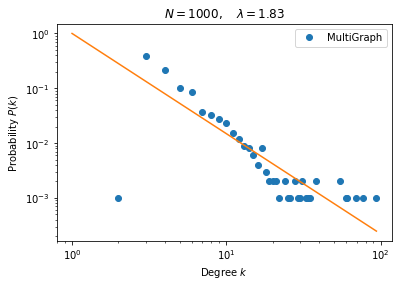

In [170]:
"""scale-free network = la probabilità che un nodo abbia grado k è più o meno k^-lambda, lambda parametro"""

"""Name: { create_scale_free }
   Param: { 
            num_nodes = numero dei nodi sulla rete
            random_edge = numero di edge base che vengono aggiunti a ogni nodo
            prob_trinage = probabiltà oltre agli edge di base di aggiungere un triangolo al nodo
            seed = seed per avere sempre la stessa rete }
   Return: {
            lambda = calcolato sulla base di una media
            graph = il network generato con la power law
            list_deg = lista dei gradi dei nodi in ordine sequenziale }
   """
def create_scale_free(num_nodes, random_edge, prob_triangle , seed):
    
    graph = nx.powerlaw_cluster_graph(num_nodes, random_edge, prob_triangle, seed)
    node_degree = list(graph.degree()) #list (node, degree)
    lamda_v = []
    current_edges = 0
    list_deg = []
    for node, degree in node_degree:
        list_deg.append(degree)

    counts = np.bincount(list_deg)
    mask = (counts > 0)
    plt.plot(np.arange(len(counts))[mask], counts[mask] / counts.sum(), "o", label="MultiGraph")
    x = np.arange(1, len(counts))

    for i in range(0, len(list_deg)):
        for j in range(0, len(counts)):
            if (j == list_deg[i]):
                lamda_v.append(np.log2(counts[j]) / list_deg[i])
    lamb = sum(lamda_v) / len(lamda_v)

    plt.plot(x, np.power(x, -lamb))
    plt.xlabel(r"Degree $k$")
    plt.xscale("log")
    plt.ylabel(r"Probability $P(k)$")
    plt.yscale("log")
    plt.title(r"$N = {0:d}, \quad \lambda = {1:.2f}$".format(num_nodes, lamb))
    plt.legend(loc="best")
    plt.show()

    return (graph, lamb, list_deg) 
    
network, lamb, list_deg = create_scale_free(1000, 3, 0.1, random.randint(0, 100000000000000000))


In [171]:
""" """
def percolation_one_node_random(network):
    
    lenght_of_list = len(network.nodes)
    value = random.randint(0, lenght_of_list-1)
    nodes = list(network.nodes)
    network.remove_node(nodes[value])
    
    return network
    
network = percolation_one_node_random(network)


In [172]:
"""percentuale di nodi tolti sul totale della rete"""

def percolation_loop_removal(network, percentage):
    
    per = round(percentage * len(network.nodes))
    print(f'Eliminated nodes = {per}')

    for i in range(0, per):
        network = percolation_one_node_random(network)
    return network

network = percolation_loop_removal(network, 0.3)

Eliminated nodes = 300
